## Bước 1: Import modules

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from tqdm import tqdm

## Bước 2: Load bộ dữ liệu NER cho tiếng Việt (PhoNER)

In [126]:
def load_phoner_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load train, dev, test data
train_data = load_phoner_data('/kaggle/input/ner-vi/train_word.json')
dev_data = load_phoner_data('/kaggle/input/ner-vi/dev_word.json')
test_data = load_phoner_data('/kaggle/input/ner-vi/test_word.json')

print(f"Số lượng câu train: {len(train_data)}")
print(f"Số lượng câu dev: {len(dev_data)}")
print(f"Số lượng câu test: {len(test_data)}")
print(f"\nVí dụ dữ liệu đầu tiên:")
print(train_data[0])

Số lượng câu train: 5027
Số lượng câu dev: 2000
Số lượng câu test: 3000

Ví dụ dữ liệu đầu tiên:
{'words': ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']}


## Bước 3: Lấy các câu và các thẻ tương ứng

In [127]:
# Extract sentences and tags 
# Training set
train_sentences = []
train_tags = []
for item in train_data:
    train_sentences.append(item['words'])
    train_tags.append(item['tags'])

# dev set
val_sentences = []
val_tags = []
for item in dev_data:
    val_sentences.append(item['words'])
    val_tags.append(item['tags'])

# Test set
test_sentences = []
test_tags = []
for item in test_data:
    test_sentences.append(item['words'])
    test_tags.append(item['tags'])

print(f"Tổng số câu training: {len(train_sentences)}")
print(f"Tổng số câu validation (dev): {len(val_sentences)}")
print(f"Tổng số câu test: {len(test_sentences)}")
print(f"\nCâu đầu tiên (train): {train_sentences[0]}")
print(f"Tags đầu tiên (train): {train_tags[0]}")
print(f"Độ dài câu đầu tiên: {len(train_sentences[0])}")

Tổng số câu training: 5027
Tổng số câu validation (dev): 2000
Tổng số câu test: 3000

Câu đầu tiên (train): ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
Tags đầu tiên (train): ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']
Độ dài câu đầu tiên: 18


## Bước 4: Ánh xạ giữa các câu và chỉ mục

In [128]:
# createword_to_idx mapping
unique_words = set()
for sentence in train_sentences:
    unique_words.update(sentence)

word_to_idx = {'<PAD>': 0, '<UNK>': 1}
for idx, word in enumerate(sorted(unique_words), start=2):
    word_to_idx[word] = idx

# create tag_to_idx mapping
unique_tags = set()
for tag_list in train_tags:
    unique_tags.update(tag_list)

tag_to_idx = {}
for idx, tag in enumerate(sorted(unique_tags)):
    tag_to_idx[tag] = idx

# Tạo reverse mapping
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

print(f"Số lượng từ duy nhất: {len(word_to_idx)}")
print(f"Số lượng tags duy nhất: {len(tag_to_idx)}")
print(f"\nTag mappings:")
print(f"tag_to_idx: {tag_to_idx}")
print(f"\nidx_to_tag: {idx_to_tag}")

Số lượng từ duy nhất: 5243
Số lượng tags duy nhất: 20

Tag mappings:
tag_to_idx: {'B-AGE': 0, 'B-DATE': 1, 'B-GENDER': 2, 'B-JOB': 3, 'B-LOCATION': 4, 'B-NAME': 5, 'B-ORGANIZATION': 6, 'B-PATIENT_ID': 7, 'B-SYMPTOM_AND_DISEASE': 8, 'B-TRANSPORTATION': 9, 'I-AGE': 10, 'I-DATE': 11, 'I-JOB': 12, 'I-LOCATION': 13, 'I-NAME': 14, 'I-ORGANIZATION': 15, 'I-PATIENT_ID': 16, 'I-SYMPTOM_AND_DISEASE': 17, 'I-TRANSPORTATION': 18, 'O': 19}

idx_to_tag: {0: 'B-AGE', 1: 'B-DATE', 2: 'B-GENDER', 3: 'B-JOB', 4: 'B-LOCATION', 5: 'B-NAME', 6: 'B-ORGANIZATION', 7: 'B-PATIENT_ID', 8: 'B-SYMPTOM_AND_DISEASE', 9: 'B-TRANSPORTATION', 10: 'I-AGE', 11: 'I-DATE', 12: 'I-JOB', 13: 'I-LOCATION', 14: 'I-NAME', 15: 'I-ORGANIZATION', 16: 'I-PATIENT_ID', 17: 'I-SYMPTOM_AND_DISEASE', 18: 'I-TRANSPORTATION', 19: 'O'}


## Bước 5: Padding đầu vào và cắt dữ liệu thành tập Train/Test

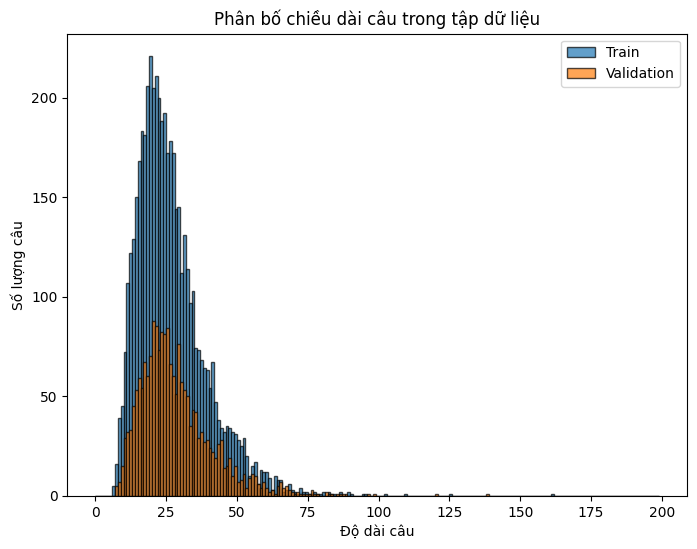

In [129]:
# biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu
plt.figure(figsize=(8, 6), dpi=100)
plt.hist([len(sentence) for sentence in train_sentences], bins=range(0, 200, 1), edgecolor='black', alpha=0.7, label='Train')
plt.hist([len(sentence) for sentence in val_sentences], bins=range(0, 200, 1), edgecolor='black', alpha=0.7, label='Validation')
plt.title('Phân bố chiều dài câu trong tập dữ liệu')
plt.xlabel('Độ dài câu')
plt.ylabel('Số lượng câu')
plt.legend()
plt.show()

Có thể thấy độ dài an toàn của câu là khoảng 90


In [130]:
max_len = 90

def process_data(sentences, tags, word_to_idx, tag_to_idx, max_len, pad_word='<PAD>', pad_tag='O'):
    """
    Convert sentences and tags to indices and padding
    """
    sentences_idx = []
    for sentence in sentences:
        sentence_idx = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in sentence]
        sentences_idx.append(sentence_idx)
    
    tags_idx = []
    for tag_list in tags:
        tag_idx = [tag_to_idx.get(tag, tag_to_idx[pad_tag]) for tag in tag_list]
        tags_idx.append(tag_idx)

    X = [torch.tensor(s, dtype=torch.long) for s in sentences_idx]
    y = [torch.tensor(t, dtype=torch.long) for t in tags_idx]
    X = pad_sequence(X, batch_first=True, padding_value=word_to_idx[pad_word])
    y = pad_sequence(y, batch_first=True, padding_value=tag_to_idx[pad_tag])
    
    # Cắt về max_len
    X = X[:, :max_len]
    y = y[:, :max_len]
    
    return X, y

In [131]:
# convert and padding training data
X_train, y_train = process_data(train_sentences, train_tags, word_to_idx, tag_to_idx, max_len)

# convert and padding validation data
X_val, y_val = process_data(val_sentences, val_tags, word_to_idx, tag_to_idx, max_len)

# convert and padding test data
X_test, y_test = process_data(test_sentences, test_tags, word_to_idx, tag_to_idx, max_len)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 5027
Validation size: 2000
Test size: 3000


## Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)

In [132]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, num_layers=1, dropout=0.5):
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)  # *2 vì bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)
        
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim * 2)
        lstm_out = self.dropout(lstm_out)
        
        tag_space = self.fc(lstm_out)  # (batch_size, seq_len, num_tags)
        return tag_space

# model configs
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 256
num_tags = len(tag_to_idx)
num_layers = 3
dropout = 0.4

model = BiLSTM_NER(vocab_size, embedding_dim, hidden_dim, num_tags, num_layers, dropout)
print(f"Model architecture:")
print(model)
print(f"\nVocab size: {vocab_size}")
print(f"Number of tags: {num_tags}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
BiLSTM_NER(
  (embedding): Embedding(5243, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=20, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

Vocab size: 5243
Number of tags: 20

Total parameters: 4,421,664
Trainable parameters: 4,421,664


## Bước 7: Huấn luyện Model

In [133]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
batch_size = 16
train_dataset = NERDataset(X_train, y_train)
val_dataset = NERDataset(X_val, y_val)
test_dataset = NERDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [134]:
# Cài đặt training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# Loss function và optimizer
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

Using device: cuda


In [135]:
for epoch in tqdm(range(num_epochs), desc="Training"):
    # Training phase
    model.train()
    train_loss = 0
    train_batches = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)  
        outputs = outputs.view(-1, num_tags)  
        batch_y = batch_y.view(-1) 
        
        # Tạo mask để ignore padding tokens 
        mask = (batch_X.view(-1) != 0).float()  
        loss_per_token = criterion(outputs, batch_y) 
        loss = (loss_per_token * mask).sum() / mask.sum()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_batches = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            outputs = outputs.view(-1, num_tags)
            batch_y = batch_y.view(-1)
            
            # Tạo mask để ignore padding tokens
            mask = (batch_X.view(-1) != 0).bool()
            loss_per_token = criterion(outputs, batch_y)
            loss = (loss_per_token * mask.float()).sum() / mask.sum()
            val_loss += loss.item()
            val_batches += 1
            
            # Tính accuracy
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(batch_y[mask].cpu().numpy())
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Tính accuracy
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_bilstm_ner_model_vi.pth')
        print(f"Epoch {epoch+1}/{num_epochs} - Best model saved!")
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print("-" * 60)

Training:   5%|▌         | 1/20 [00:09<02:55,  9.24s/it]

Epoch 1/20 - Best model saved!
Epoch 1/20
 Train Loss: 0.5932 | Val Loss: 0.2913 | Val Accuracy: 0.9174
------------------------------------------------------------


Training:  10%|█         | 2/20 [00:18<02:46,  9.26s/it]

Epoch 2/20 - Best model saved!
Epoch 2/20
 Train Loss: 0.1995 | Val Loss: 0.2007 | Val Accuracy: 0.9422
------------------------------------------------------------


Training:  15%|█▌        | 3/20 [00:27<02:36,  9.22s/it]

Epoch 3/20 - Best model saved!
Epoch 3/20
 Train Loss: 0.1424 | Val Loss: 0.1650 | Val Accuracy: 0.9515
------------------------------------------------------------


Training:  20%|██        | 4/20 [00:36<02:27,  9.20s/it]

Epoch 4/20 - Best model saved!
Epoch 4/20
 Train Loss: 0.1131 | Val Loss: 0.1503 | Val Accuracy: 0.9567
------------------------------------------------------------


Training:  25%|██▌       | 5/20 [00:46<02:18,  9.24s/it]

Epoch 5/20 - Best model saved!
Epoch 5/20
 Train Loss: 0.0918 | Val Loss: 0.1393 | Val Accuracy: 0.9609
------------------------------------------------------------


Training:  30%|███       | 6/20 [00:55<02:09,  9.24s/it]

Epoch 6/20
 Train Loss: 0.0780 | Val Loss: 0.1408 | Val Accuracy: 0.9603
------------------------------------------------------------


Training:  35%|███▌      | 7/20 [01:04<01:59,  9.21s/it]

Epoch 7/20
 Train Loss: 0.0659 | Val Loss: 0.1431 | Val Accuracy: 0.9631
------------------------------------------------------------


Training:  40%|████      | 8/20 [01:13<01:50,  9.21s/it]

Epoch 8/20
 Train Loss: 0.0602 | Val Loss: 0.1422 | Val Accuracy: 0.9627
------------------------------------------------------------


Training:  45%|████▌     | 9/20 [01:23<01:41,  9.23s/it]

Epoch 9/20 - Best model saved!
Epoch 9/20
 Train Loss: 0.0526 | Val Loss: 0.1390 | Val Accuracy: 0.9647
------------------------------------------------------------


Training:  50%|█████     | 10/20 [01:32<01:32,  9.26s/it]

Epoch 10/20 - Best model saved!
Epoch 10/20
 Train Loss: 0.0458 | Val Loss: 0.1354 | Val Accuracy: 0.9660
------------------------------------------------------------


Training:  55%|█████▌    | 11/20 [01:41<01:23,  9.25s/it]

Epoch 11/20
 Train Loss: 0.0407 | Val Loss: 0.1511 | Val Accuracy: 0.9642
------------------------------------------------------------


Training:  60%|██████    | 12/20 [01:50<01:14,  9.25s/it]

Epoch 12/20
 Train Loss: 0.0390 | Val Loss: 0.1472 | Val Accuracy: 0.9632
------------------------------------------------------------


Training:  65%|██████▌   | 13/20 [02:00<01:04,  9.27s/it]

Epoch 13/20
 Train Loss: 0.0367 | Val Loss: 0.1428 | Val Accuracy: 0.9655
------------------------------------------------------------


Training:  70%|███████   | 14/20 [02:09<00:55,  9.27s/it]

Epoch 14/20
 Train Loss: 0.0300 | Val Loss: 0.1459 | Val Accuracy: 0.9672
------------------------------------------------------------


Training:  75%|███████▌  | 15/20 [02:18<00:46,  9.26s/it]

Epoch 15/20
 Train Loss: 0.0301 | Val Loss: 0.1354 | Val Accuracy: 0.9678
------------------------------------------------------------


Training:  80%|████████  | 16/20 [02:27<00:37,  9.25s/it]

Epoch 16/20
 Train Loss: 0.0288 | Val Loss: 0.1544 | Val Accuracy: 0.9667
------------------------------------------------------------


Training:  85%|████████▌ | 17/20 [02:37<00:27,  9.27s/it]

Epoch 17/20
 Train Loss: 0.0280 | Val Loss: 0.1434 | Val Accuracy: 0.9668
------------------------------------------------------------


Training:  90%|█████████ | 18/20 [02:46<00:18,  9.29s/it]

Epoch 18/20
 Train Loss: 0.0264 | Val Loss: 0.1455 | Val Accuracy: 0.9667
------------------------------------------------------------


Training:  95%|█████████▌| 19/20 [02:55<00:09,  9.28s/it]

Epoch 19/20
 Train Loss: 0.0217 | Val Loss: 0.1614 | Val Accuracy: 0.9667
------------------------------------------------------------


Training: 100%|██████████| 20/20 [03:05<00:00,  9.25s/it]

Epoch 20/20
 Train Loss: 0.0251 | Val Loss: 0.1600 | Val Accuracy: 0.9663
------------------------------------------------------------


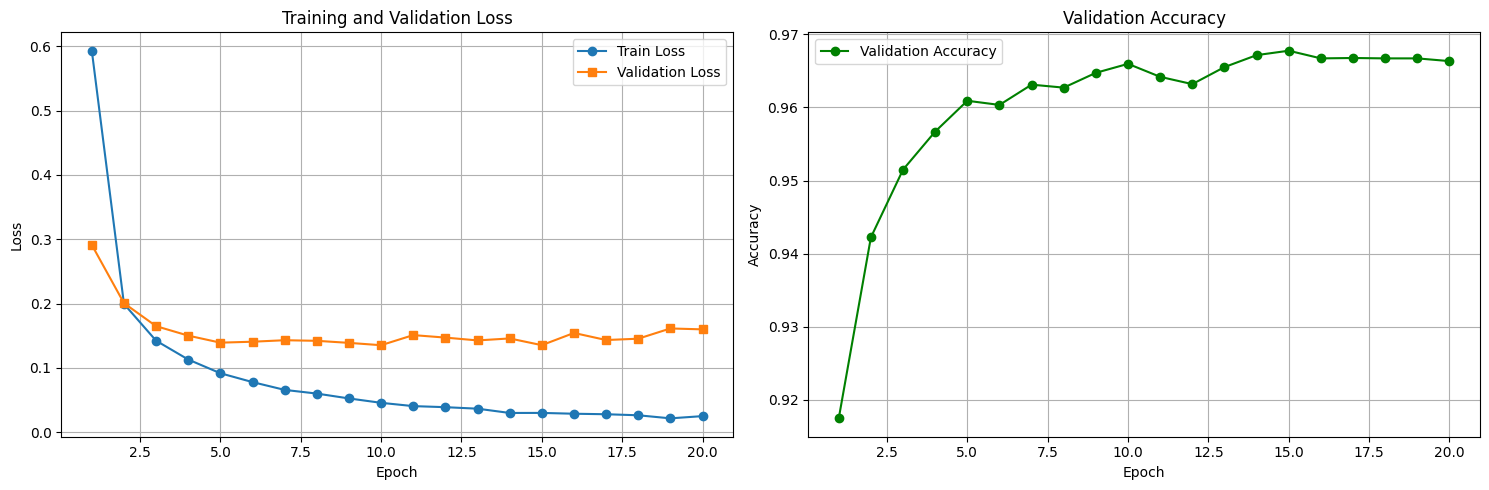

In [136]:
# Vẽ biểu đồ loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ loss
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Biểu đồ accuracy
ax2.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Bước 8: Đánh giá mô hình

In [137]:
# Load best model để đánh giá
model.load_state_dict(torch.load('best_bilstm_ner_model_vi.pth'))
model.eval()

# Đánh giá trên test set
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        outputs = model(batch_X)
        outputs = outputs.view(-1, num_tags)
        batch_y = batch_y.view(-1)
        
        # Tạo mask để ignore padding tokens
        mask = (batch_X.view(-1) != 0).bool()
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds[mask].cpu().numpy())
        all_labels.extend(batch_y[mask].cpu().numpy())

In [138]:
# Tính các độ đo tổng hợp
accuracy_micro = accuracy_score(all_labels, all_preds)
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# Tính accuracy và F1-score cho từng tag
tag_names = [idx_to_tag[i] for i in range(len(tag_to_idx))]
tag_accuracies = []
tag_f1_scores = []

for tag_idx in range(len(tag_to_idx)):
    tag_mask = [label == tag_idx for label in all_labels]
    num_tag_samples = sum(tag_mask)
    
    if num_tag_samples > 0:
        # Tính accuracy: số tokens được predict đúng / tổng số tokens của tag này
        correct = sum([all_labels[i] == all_preds[i] for i in range(len(all_labels)) if tag_mask[i]])
        tag_acc = correct / num_tag_samples
        
        # Tính F1-score cho tag này
        binary_labels = [1 if label == tag_idx else 0 for label in all_labels]
        binary_preds = [1 if pred == tag_idx else 0 for pred in all_preds]
        tag_f1 = f1_score(binary_labels, binary_preds, zero_division=0)
    else:
        tag_acc = 0.0
        tag_f1 = 0.0
    
    tag_accuracies.append(tag_acc)
    tag_f1_scores.append(tag_f1)

# Tính Accuracy (Macro)
accuracy_macro = np.mean(tag_accuracies)

# Tạo bảng kết quả
results_df = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': [f'{acc:.4f}' for acc in tag_accuracies],
    'F1-Score': [f'{f1:.4f}' for f1 in tag_f1_scores]
})

results_df_numeric = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': tag_accuracies,
    'F1-Score': tag_f1_scores
})

# In kết quả tổng hợp
print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP")
print("=" * 70)
print(f"Accuracy (Micro): {accuracy_micro:.4f}")
print(f"Accuracy (Macro): {accuracy_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

# Xuất kết quả cho từng nhãn thực thể
print("\n" + "=" * 70)
print("KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ")
print("=" * 70)
print(results_df.to_string(index=False))

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=tag_names, digits=4))

KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP
Accuracy (Micro): 0.9606
Accuracy (Macro): 0.7114
F1-Score (Micro): 0.9606
F1-Score (Macro): 0.7401

KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ
                  Tag Accuracy F1-Score
                B-AGE   0.9668   0.9381
               B-DATE   0.9788   0.9647
             B-GENDER   0.9624   0.9315
                B-JOB   0.5549   0.6214
           B-LOCATION   0.9411   0.9120
               B-NAME   0.5981   0.6835
       B-ORGANIZATION   0.7990   0.8398
         B-PATIENT_ID   0.9561   0.9303
B-SYMPTOM_AND_DISEASE   0.8169   0.8681
     B-TRANSPORTATION   0.8601   0.8760
                I-AGE   0.0000   0.0000
               I-DATE   0.9948   0.9824
                I-JOB   0.3596   0.4824
           I-LOCATION   0.9056   0.9104
               I-NAME   0.3846   0.5263
       I-ORGANIZATION   0.8361   0.8649
         I-PATIENT_ID   0.0000   0.0000
I-SYMPTOM_AND_DISEASE   0.7355   0.8175
     I-TRANSPORTATION   0.5942   0.6721
                    O   0.9840  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


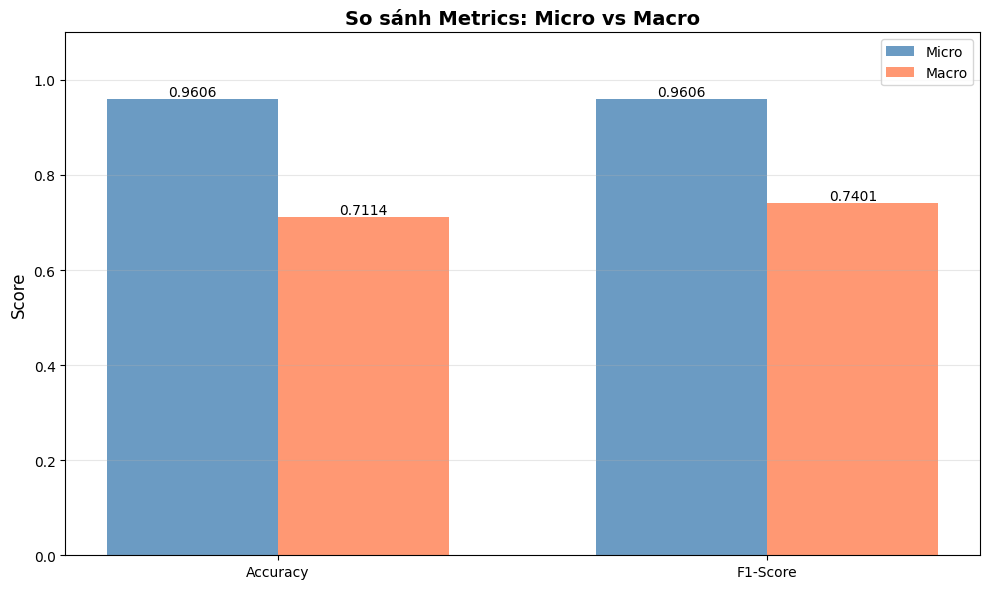

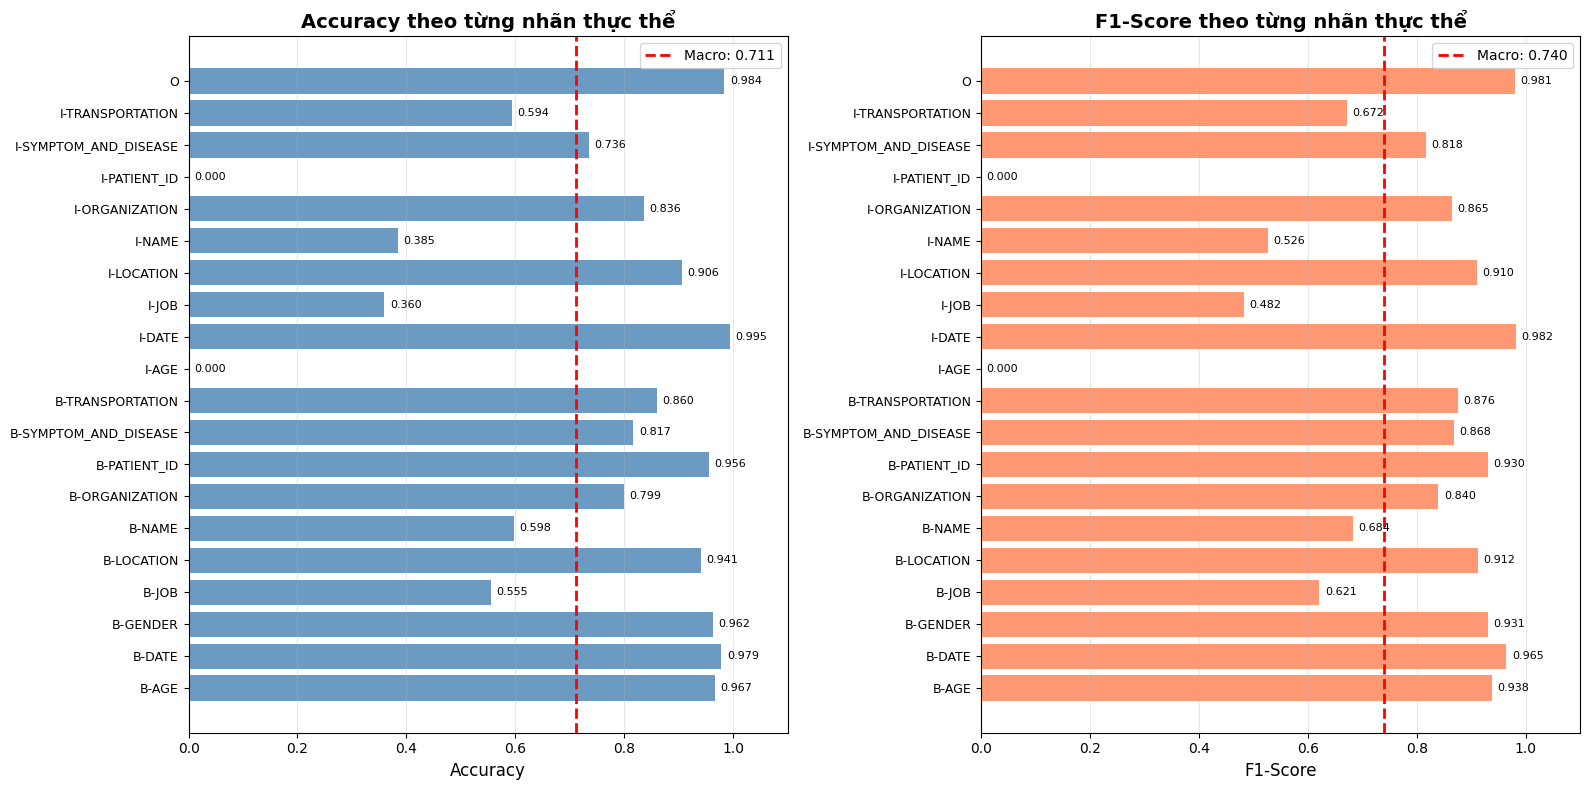

In [139]:
# Visualization: So sánh Micro vs Macro
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [accuracy_micro, f1_micro], width, label='Micro', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, [accuracy_macro, f1_macro], width, label='Macro', alpha=0.8, color='coral')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('So sánh Metrics: Micro vs Macro', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Kết quả theo từng tag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
x_pos = np.arange(len(tag_names))

# Bar chart Accuracy
bars1 = ax1.barh(x_pos, tag_accuracies, alpha=0.8, color='steelblue')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(tag_names, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1.1])
ax1.axvline(x=accuracy_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {accuracy_macro:.3f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, acc) in enumerate(zip(bars1, tag_accuracies)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Bar chart F1-Score
bars2 = ax2.barh(x_pos, tag_f1_scores, alpha=0.8, color='coral')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(tag_names, fontsize=9)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.1])
ax2.axvline(x=f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {f1_macro:.3f}')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, f1) in enumerate(zip(bars2, tag_f1_scores)):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{f1:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Bước 9: Lưu model

In [140]:
torch.save(model.state_dict(), '/kaggle/working/checkpoints_cau2')